In [76]:
import os
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['font.family'] = 'Times New Roman'  

import numpy as np
import pandas as pd

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.metrics import roc_auc_score


### 1.导入数据

In [77]:
df = pd.read_table('../dataset/amazon-books-100k.txt',
                   sep = ',')
df_clean = df.drop_duplicates()

df_clean['hist_cate_list'] = df_clean['hist_cate_list'].apply(lambda x: x.split('|'))
df_clean['hist_item_list'] = df_clean['hist_item_list'].apply(lambda x: x.split('|'))
df_clean

,label,userID,itemID,cateID,hist_item_list,hist_cate_list
0,0,AZPJ9LUT0FEPY,B00AMNNTIA,Literature & Fiction,"[0307744434, 0062248391, 0470530707, 097892462...","[Books, Books, Books, Books, Books]"
1,1,AZPJ9LUT0FEPY,0800731603,Books,"[0307744434, 0062248391, 0470530707, 097892462...","[Books, Books, Books, Books, Books]"
2,0,A2NRV79GKAU726,B003NNV10O,Russian,"[0814472869, 0071462074, 1583942300, 081253836...","[Books, Books, Books, Books, Baking, Books, Bo..."
3,1,A2NRV79GKAU726,B000UWJ91O,Books,"[0814472869, 0071462074, 1583942300, 081253836...","[Books, Books, Books, Books, Baking, Books, Bo..."
4,0,A2GEQVDX2LL4V3,0321334094,Books,"[0743596870, 0374280991, 1439140634, 0976475731]","[Books, Books, Books, Books]"
...,...,...,...,...,...,...
89994,0,A3CV7NJJC20JTB,098488789X,Books,"[034545197X, 0765326396, 1605420832, 1451648448]","[Books, Books, Books, Books]"
89995,1,A3CV7NJJC20JTB,0307381277,Books,"[034545197X, 0765326396, 1605420832, 1451648448]","[Books, Books, Books, Books]"
89996,0,A208PSIK2APSKN,0957496184,Books,"[0515140791, 147674355X, B0055ECOUA, B007JE1B1...","[Books, Books, Bibles, Literature & Fiction, L..."
89997,1,A208PSIK2APSKN,1480198854,Books,"[0515140791, 147674355X, B0055ECOUA, B007JE1B1...","[Books, Books, Bibles, Literature & Fiction, L..."


### 1.1 数据预处理
将数据转化为Ordinal序列数据

In [78]:
unique_user_ID = len(df['userID'].unique())
unique_item_ID = len(df['itemID'].unique())
unique_cate_ID = len(df['cateID'].unique())

In [79]:
userID_encoder = OrdinalEncoder()
# cateID_encoder = OrdinalEncoder()

user_id = userID_encoder.fit_transform(df_clean['userID'].values.reshape(-1,1))
# cate_id = cateID_encoder.fit_transform(df_clean['cateID'].values.reshape(-1,1))

df_clean['Ordinal_userID'] = user_id.astype('int')
# df_clean['Ordinal_cateID'] = cate_id.astype('int')


#这里手动将数据历史行为处理为ordinal-hot 编码
item_set = set()
for data in df_clean['hist_item_list']:
    item_set.update(data)

#把所有itemID加入到item_set中,以免出现漏掉情况
item_set.update(df_clean['itemID'].values)
item_to_index = {item: index for index, item in enumerate(item_set, start = 1) } #从1开始,后面用0来表示没有历史行为

#处理hist_item_list
def encode_list(item_list):
    return [item_to_index[item] for item in item_list ]

df_clean['Ordinal_hist_item_list'] = df_clean['hist_item_list'].apply(encode_list)

#处理itemID
def eoncode_item(item):
    return item_to_index[item]

df_clean['Ordinal_itemID'] = df_clean['itemID'].apply(eoncode_item)

#处理hist_cate_list
cat_set = set()
for data in df_clean['hist_cate_list']:
    cat_set.update(data)

#把所有cateID加入到cat_set中,以免出现漏掉情况
cat_set.update(df_clean['cateID'].values)

cate_to_index = {item: index for index, item in enumerate(cat_set,start= 1)} #从1开始

def encode_cate_list(cate_list):
    return [cate_to_index[item] for item in cate_list ]
df_clean['Ordinal_hist_cate_list'] = df_clean['hist_cate_list'].apply(encode_cate_list)

def eoncode_cate(cate):
    return cate_to_index[cate]

df_clean['Ordinal_cateID'] = df_clean['cateID'].apply(eoncode_cate)

df_clean



,label,userID,itemID,cateID,hist_item_list,hist_cate_list,Ordinal_userID,Ordinal_hist_item_list,Ordinal_itemID,Ordinal_hist_cate_list,Ordinal_cateID
0,0,AZPJ9LUT0FEPY,B00AMNNTIA,Literature & Fiction,"[0307744434, 0062248391, 0470530707, 097892462...","[Books, Books, Books, Books, Books]",44917,"[206424, 142847, 182786, 69605, 197011]",68074,"[386, 386, 386, 386, 386]",419
1,1,AZPJ9LUT0FEPY,0800731603,Books,"[0307744434, 0062248391, 0470530707, 097892462...","[Books, Books, Books, Books, Books]",44917,"[206424, 142847, 182786, 69605, 197011]",101880,"[386, 386, 386, 386, 386]",386
2,0,A2NRV79GKAU726,B003NNV10O,Russian,"[0814472869, 0071462074, 1583942300, 081253836...","[Books, Books, Books, Books, Baking, Books, Bo...",19804,"[39611, 8015, 78315, 2890, 54255, 137135, 124338]",6163,"[386, 386, 386, 386, 300, 386, 386]",264
3,1,A2NRV79GKAU726,B000UWJ91O,Books,"[0814472869, 0071462074, 1583942300, 081253836...","[Books, Books, Books, Books, Baking, Books, Bo...",19804,"[39611, 8015, 78315, 2890, 54255, 137135, 124338]",21400,"[386, 386, 386, 386, 300, 386, 386]",386
4,0,A2GEQVDX2LL4V3,0321334094,Books,"[0743596870, 0374280991, 1439140634, 0976475731]","[Books, Books, Books, Books]",17385,"[30271, 97772, 12556, 137554]",220405,"[386, 386, 386, 386]",386
...,...,...,...,...,...,...,...,...,...,...,...
89994,0,A3CV7NJJC20JTB,098488789X,Books,"[034545197X, 0765326396, 1605420832, 1451648448]","[Books, Books, Books, Books]",28177,"[98594, 185606, 19190, 15365]",210244,"[386, 386, 386, 386]",386
89995,1,A3CV7NJJC20JTB,0307381277,Books,"[034545197X, 0765326396, 1605420832, 1451648448]","[Books, Books, Books, Books]",28177,"[98594, 185606, 19190, 15365]",16915,"[386, 386, 386, 386]",386
89996,0,A208PSIK2APSKN,0957496184,Books,"[0515140791, 147674355X, B0055ECOUA, B007JE1B1...","[Books, Books, Bibles, Literature & Fiction, L...",12193,"[24471, 189598, 130748, 33111, 100134]",23175,"[386, 386, 365, 419, 419]",386
89997,1,A208PSIK2APSKN,1480198854,Books,"[0515140791, 147674355X, B0055ECOUA, B007JE1B1...","[Books, Books, Bibles, Literature & Fiction, L...",12193,"[24471, 189598, 130748, 33111, 100134]",114216,"[386, 386, 365, 419, 419]",386


In [80]:
data = df_clean.drop(['userID', 'itemID', 'cateID', 'hist_item_list',
       'hist_cate_list'], axis = 1)

#到换下顺序
data = data[['label','Ordinal_userID', 'Ordinal_itemID', 'Ordinal_cateID', 'Ordinal_hist_item_list', 'Ordinal_hist_cate_list']]
data

,label,Ordinal_userID,Ordinal_itemID,Ordinal_cateID,Ordinal_hist_item_list,Ordinal_hist_cate_list
0,0,44917,68074,419,"[206424, 142847, 182786, 69605, 197011]","[386, 386, 386, 386, 386]"
1,1,44917,101880,386,"[206424, 142847, 182786, 69605, 197011]","[386, 386, 386, 386, 386]"
2,0,19804,6163,264,"[39611, 8015, 78315, 2890, 54255, 137135, 124338]","[386, 386, 386, 386, 300, 386, 386]"
3,1,19804,21400,386,"[39611, 8015, 78315, 2890, 54255, 137135, 124338]","[386, 386, 386, 386, 300, 386, 386]"
4,0,17385,220405,386,"[30271, 97772, 12556, 137554]","[386, 386, 386, 386]"
...,...,...,...,...,...,...
89994,0,28177,210244,386,"[98594, 185606, 19190, 15365]","[386, 386, 386, 386]"
89995,1,28177,16915,386,"[98594, 185606, 19190, 15365]","[386, 386, 386, 386]"
89996,0,12193,23175,386,"[24471, 189598, 130748, 33111, 100134]","[386, 386, 365, 419, 419]"
89997,1,12193,114216,386,"[24471, 189598, 130748, 33111, 100134]","[386, 386, 365, 419, 419]"


### 1.3 历史数据进行对齐处理
为了简化,仅使用最后5个数据参与预测,如果没有则使用0填充

In [81]:
def clean_data(item_list):
    #截取最后5个数据
    last_5 = item_list[-5:]
    #如果不足5个,则用0填充
    if len(last_5) < 5:
        last_5 = [0] * (5 - len(last_5)) + last_5
    return last_5

data['Ordinal_hist_item_list'] = data['Ordinal_hist_item_list'].apply(clean_data)
data['Ordinal_hist_cate_list'] = data['Ordinal_hist_cate_list'].apply(clean_data)

data


,label,Ordinal_userID,Ordinal_itemID,Ordinal_cateID,Ordinal_hist_item_list,Ordinal_hist_cate_list
0,0,44917,68074,419,"[206424, 142847, 182786, 69605, 197011]","[386, 386, 386, 386, 386]"
1,1,44917,101880,386,"[206424, 142847, 182786, 69605, 197011]","[386, 386, 386, 386, 386]"
2,0,19804,6163,264,"[78315, 2890, 54255, 137135, 124338]","[386, 386, 300, 386, 386]"
3,1,19804,21400,386,"[78315, 2890, 54255, 137135, 124338]","[386, 386, 300, 386, 386]"
4,0,17385,220405,386,"[0, 30271, 97772, 12556, 137554]","[0, 386, 386, 386, 386]"
...,...,...,...,...,...,...
89994,0,28177,210244,386,"[0, 98594, 185606, 19190, 15365]","[0, 386, 386, 386, 386]"
89995,1,28177,16915,386,"[0, 98594, 185606, 19190, 15365]","[0, 386, 386, 386, 386]"
89996,0,12193,23175,386,"[24471, 189598, 130748, 33111, 100134]","[386, 386, 365, 419, 419]"
89997,1,12193,114216,386,"[24471, 189598, 130748, 33111, 100134]","[386, 386, 365, 419, 419]"


可以看到我们的数据都已经成功转为了数据型数据,并且做好了对齐准备,可以进行下一步建模了

### 2. 模型构建
- 注意可以看到DIN中的Activation unit 与初始论文中使用外积不同,王喆中给出的例子是使用元素减的操作,其实也是用来表示两个物品的差异
- 并且使用的激活函数为PRelu/Dice(36),这里为了简化使用Relu

In [82]:
class Dice(nn.Module):
    def __init__(self, alpha=0.0, epsilon=1e-8):
        """
        初始化 Dice 激活函数。
        :param alpha: 可学习的参数，用于控制负值部分的缩放。
        :param epsilon: 一个小常数，用于数值稳定性。
        """
        super(Dice, self).__init__()
        self.alpha = nn.Parameter(torch.tensor(alpha))  # 可学习参数
        self.epsilon = epsilon

    def forward(self, x):
        """
        前向传播函数。
        :param x: 输入张量，形状为 (batch_size, ...)。
        :return: 经过 Dice 激活后的张量。
        """
        # 计算输入 x 的均值和方差
        mean = x.mean(dim=0, keepdim=True)  # 沿 batch 维度计算均值，保留维度
        var = x.var(dim=0, keepdim=True, unbiased=False)  # 沿 batch 维度计算方差，不使用无偏估计

        # 计算控制函数 p(s)
        p_s = 1 / (1 + torch.exp(-(x - mean) / torch.sqrt(var + self.epsilon)))

        # 应用 Dice 激活函数
        output = p_s * x + (1 - p_s) * self.alpha * x
        return output

In [83]:
#定义激活单元（Activation Unit）
class LocalActivationUnit(nn.Module):
    def __init__(self, embedding_dim, hidden_units = [36,18], dropout = 0.5):
        super(LocalActivationUnit, self).__init__()
        
        layers = []
        input_dim = embedding_dim  *2 * 3 #开始的输入维度为 cate和behavior的cat所以得乘2
        for dim in hidden_units:
            layers.append(nn.Linear(input_dim, dim))
            layers.append(Dice())
            layers.append(nn.Dropout(dropout))
            input_dim = dim
        layers.append(nn.Linear(input_dim, 1))
        
        self.mlp = nn.Sequential(*layers)

    def forward(self, behavior_embeds, target_embed, mask):
        """
        Args:
            behavior_embeds: 历史行为序列嵌入 (batch_size, seq_len, embed_dim)
            target_embed: 候选物品嵌入 (batch_size, embed_dim)
            mask: 序列填充掩码 (batch_size, seq_len)
        Returns:
            注意力权重 (batch_size, seq_len)
        """
        seq_len = behavior_embeds.size(1)
        # 扩展候选物品嵌入以匹配序列长度
        target_embed = target_embed.unsqueeze(1).expand(-1, seq_len, - 1) #-1：表示保留该维度的原始大小,seq_len：表示将第 1 维（即新增的维度）扩展到与 behavior_embeds 的序列长度一致。


        #拼接行为序列和候选物品嵌入
        concat_embeds = torch.cat([behavior_embeds, target_embed, target_embed - behavior_embeds], dim = -1) #最后一个维度进行拼接
        #计算每一个序列的权重
        scores = self.mlp(concat_embeds).squeeze(-1) #(batch_size, seq_len, 1) 转换为 (batch_size, seq_len)
    
        #应用sigmoid获取权重
        weights = torch.sigmoid(scores) #(batch_size, seq_len)

        if mask is not None:
            weights = weights * mask #(batch_size, seq_len)
        return weights




In [84]:
class DIN(nn.Module):
    """
    Args:
        user_feat_dims: 用户特征维度字典
        item_feat_dims: 总物品特征维度字典
        context_feat_dims: 上下文特征维度字典, 如果没有上下文特征，可以设置为 None
        embedding_dim: 嵌入维度
        mlp_dims: MLP隐藏层维度列表
        dropout: Dropout概率
    
    Output:
        预测结果这里并没有使用sigmoid激活，而是通过softmax输出两个类别的概率
    """
    def __init__(self, user_feat_dims, item_feat_dims, context_feat_dims, 
                 embedding_dim=8, mlp_dims=[200, 80], dropout=0.2):
        super(DIN, self).__init__()

        # 用户特征嵌入层
        self.user_embeddings = nn.ModuleDict({
            feat: nn.Embedding(dim, embedding_dim)
            for feat, dim in user_feat_dims.items()
        })

        # 物品特征嵌入层
        self.item_embeddings = nn.ModuleDict({
            feat: nn.Embedding(dim, embedding_dim)
            for feat, dim in item_feat_dims.items()
        })

        # 上下文特征层
        self.context_embeddings = None
        self.context_embed_size = 0
        if context_feat_dims is not None:
            self.context_embeddings = nn.ModuleDict({
                feat: nn.Embedding(dim, embedding_dim)
                for feat, dim in context_feat_dims.items()
            })
            self.context_embed_size = len(context_feat_dims) * embedding_dim

        # 注意力单元层
        self.attention = LocalActivationUnit(embedding_dim, hidden_units=[80, 40], dropout=dropout)

        # 计算MLP输入维度
        user_embed_size = len(user_feat_dims) * embedding_dim
        item_embed_size = len(item_feat_dims) * embedding_dim

        mlp_input_dim = user_embed_size + item_embed_size + self.context_embed_size + embedding_dim*2  # 最后一个是user_interest维度,因为使用了item_id和cate_id 所以维度是2 * embedding_dim

        # MLP层
        mlp_layers = []
        input_dim = mlp_input_dim

        for hidden_dim in mlp_dims:
            mlp_layers.append(nn.Linear(input_dim, hidden_dim))
            mlp_layers.append(Dice())
            mlp_layers.append(nn.Dropout(dropout))
            input_dim = hidden_dim
        
        mlp_layers.append(nn.Linear(input_dim, 2))
        self.mlp = nn.Sequential(*mlp_layers)

    def forward(self, user_features, target_item_features, context_features, hist_behavior_seq, hist_cate_seq):
        """
        Args:
            user_features: 用户特征字典
            target_item_features: 目标物品特征字典
            context_features: 上下文特征字典
            hist_behavior_seq: 历史行为序列，形状为(batch_size, seq_len)
            hist_cate_seq: 历史行为类别列表，形状为(batch_size, seq_len)
        Returns:
            预测结果
        """
        # 生成序列掩码,因为数据中做了对齐,没有数据的部分值已被填为了0
        
        if hist_behavior_seq is not None:
            # 确保 hist_behavior_seq 是布尔张量
            mask = (hist_behavior_seq != 0).float()
        else:
            mask = None


        # 用户特征嵌入
        user_embeds = [
            self.user_embeddings[feat](user_features[feat]) for feat in user_features
        ]
        user_embeds = torch.cat(user_embeds, dim=1)  # (batch_size, user_embed_size)

        # 目标特征嵌入
        item_embeds = [
            self.item_embeddings[feat](target_item_features[feat]) for feat in target_item_features
        ]
        target_item_embed = torch.cat(item_embeds, dim=1)  # (batch_size, item_embed_size)

        # 上下文特征嵌入,如果没有上下文特征，就用0填充
        context_embed = torch.zeros(len(user_embeds), self.context_embed_size).to(user_embeds.device)
        if self.context_embeddings is not None:
            context_embeds = [
                self.context_embeddings[feat](context_features[feat]) for feat in context_features
            ]
            context_embed = torch.cat(context_embeds, dim=1)  # (batch_size, context_embed_size)

        # 历史行为序列处理
        if len(hist_behavior_seq) > 0 and len(hist_cate_seq) > 0:
            hist_behavior_embed = self.item_embeddings['Ordinal_itemID'](hist_behavior_seq)  # (batch_size, seq_len, item_embed_size)
            hist_cate_embed = self.item_embeddings['Ordinal_cateID'](hist_cate_seq)  # (batch_size, seq_len, item_embed_size)
            
            hist_embed = torch.cat([hist_behavior_embed, hist_cate_embed], dim=2)  # (batch_size, seq_len, item_embed_size*2)
            weights = self.attention(hist_embed, target_item_embed, mask)  # (batch_size, seq_len)
            user_interest = torch.sum(hist_embed * weights.unsqueeze(-1), dim=1)  # (batch_size, item_embed_size * 2)
        else:
            user_interest = torch.zeros(len(user_embeds), self.item_embeddings['Ordinal_itemID'].embedding_dim).to(user_embeds.device)

        # 拼接特征
        combined = torch.cat([user_embeds, target_item_embed, context_embed, user_interest], dim=1)  # (batch_size, mlp_input_dim)

        # 通过MLP获取预测结果
        logit = self.mlp(combined).squeeze(-1)
        output = torch.softmax(logit, dim=1)
        return output

### 3. 模型构建

In [85]:
#参数设定
batch_size = 64
embedding_dim = 16
mlp_dims = [200, 80]
dropout = 0.5
lr = 1e-3
l2_weight_decay = 1e-5
epoch = 20
test_size = 0.2

# 特征维度配置
user_feat_dims = {'Ordinal_userID': data['Ordinal_userID'].nunique()}
item_feat_dims = {'Ordinal_itemID': len(item_to_index) + 1, 'Ordinal_cateID' : len(cate_to_index) + 1 } #注意这里的+1是因为要考虑到0的情况
#context_feat_dims = {'hour': 24} #上下文特征维度,但是因为没有这部分数据，所以注释掉


In [86]:
# 数据集处理
class ReccommenderDataset(Dataset):
    def __init__(self, data):
        self.user_features = {
            'Ordinal_userID': torch.tensor(data['Ordinal_userID'].values),
        }

        self.target_item_features = {
            'Ordinal_itemID': torch.tensor(data['Ordinal_itemID'].values),
            'Ordinal_cateID': torch.tensor(data['Ordinal_cateID'].values),
        }

        self.y = torch.tensor(data['label'].values, dtype=torch.long)

        # 上下文特征,但是因为没有这部分数据，所以注释掉
        #self.context_features = None
        
        # 历史行为序列转为tensor
        self.hist_behavior_seq = [torch.tensor(seq, dtype=torch.long) for seq in data['Ordinal_hist_item_list']]
        self.hist_cate_seq = [torch.tensor(seq, dtype=torch.long) for seq in data['Ordinal_hist_cate_list']]


        # 拼接成单个张量
        self.hist_behavior_seq = torch.stack(self.hist_behavior_seq, dim=0) # 维度为 (batch_size, seq_len)
        self.hist_cate_seq = torch.stack(self.hist_cate_seq, dim=0)         # 维度为 (batch_size, seq_len)

    def __len__(self):
        return len(self.user_features['Ordinal_userID'])


    def __getitem__(self, idx):
        return {
            'user_features' : {key: self.user_features[key][idx] for key in self.user_features},
            'target_item_features' : {key: self.target_item_features[key][idx] for key in self.target_item_features},
            'hist_behavior_seq' : self.hist_behavior_seq[idx],
            'hist_cate_seq': self.hist_cate_seq[idx],
            'label' : self.y[idx],
        }
    

#划分训练集和测试集
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_dataset = ReccommenderDataset(train_data)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 测试集
test_dataset = ReccommenderDataset(test_data)  # 直接用 test_data 创建 test_dataset

# 获取测试集的数据
test_user_features = test_dataset.user_features  # 直接从 test_dataset 获取
test_target_item_features = test_dataset.target_item_features  # 获取目标物品特征
test_hist_behavior_seq = test_dataset.hist_behavior_seq  # 获取历史行为序列
test_hist_cate_seq = test_dataset.hist_cate_seq  # 获取历史类别序列
test_labels = test_dataset.y  # 获取标签




In [87]:
model = DIN(user_feat_dims, item_feat_dims, context_feat_dims = None, embedding_dim=embedding_dim, mlp_dims=mlp_dims, dropout=dropout)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay= l2_weight_decay)

In [88]:
#模型训练
pbar = tqdm(range(epoch), desc='[Training]')
trian_loss_history = []
test_loss_history = []
auc_history = []

for epoch in pbar:
    model.train()
    running_loss = 0.0
    running_auc = 0.0

    for batch in train_dataloader:
        user_features = batch['user_features']
        target_item_features = batch['target_item_features']
        hist_behavior_seq = batch['hist_behavior_seq']
        hist_cate_seq = batch['hist_cate_seq']
        context_features = None
        label = batch['label']

        # 前向传播
        output = model(user_features, target_item_features, context_features, hist_behavior_seq, hist_cate_seq)

        # 反向传播
        optimizer.zero_grad()
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    epoch_loss = running_loss / len(train_dataloader)
    trian_loss_history.append(epoch_loss)

    #测试集
    model.eval()
    with torch.no_grad():
         y_pred = model(test_user_features, test_target_item_features, context_features = None, hist_behavior_seq = test_hist_behavior_seq, hist_cate_seq = test_hist_cate_seq)
         test_loss = criterion(y_pred, test_labels)
         test_loss_history.append(test_loss.item())
         y_pred = y_pred[:, 1]
         test_auc = roc_auc_score(test_labels.detach().numpy(), y_pred.detach().numpy())
         auc_history.append(test_auc)

    pbar.set_postfix({'train_loss': epoch_loss, 'test_loss': test_loss.item(), 'test_auc': test_auc})
    

    



[Training]: 100%|██████████| 20/20 [05:42<00:00, 17.12s/it, train_loss=0.402, test_loss=0.718, test_auc=0.613]


### 4数据可视化

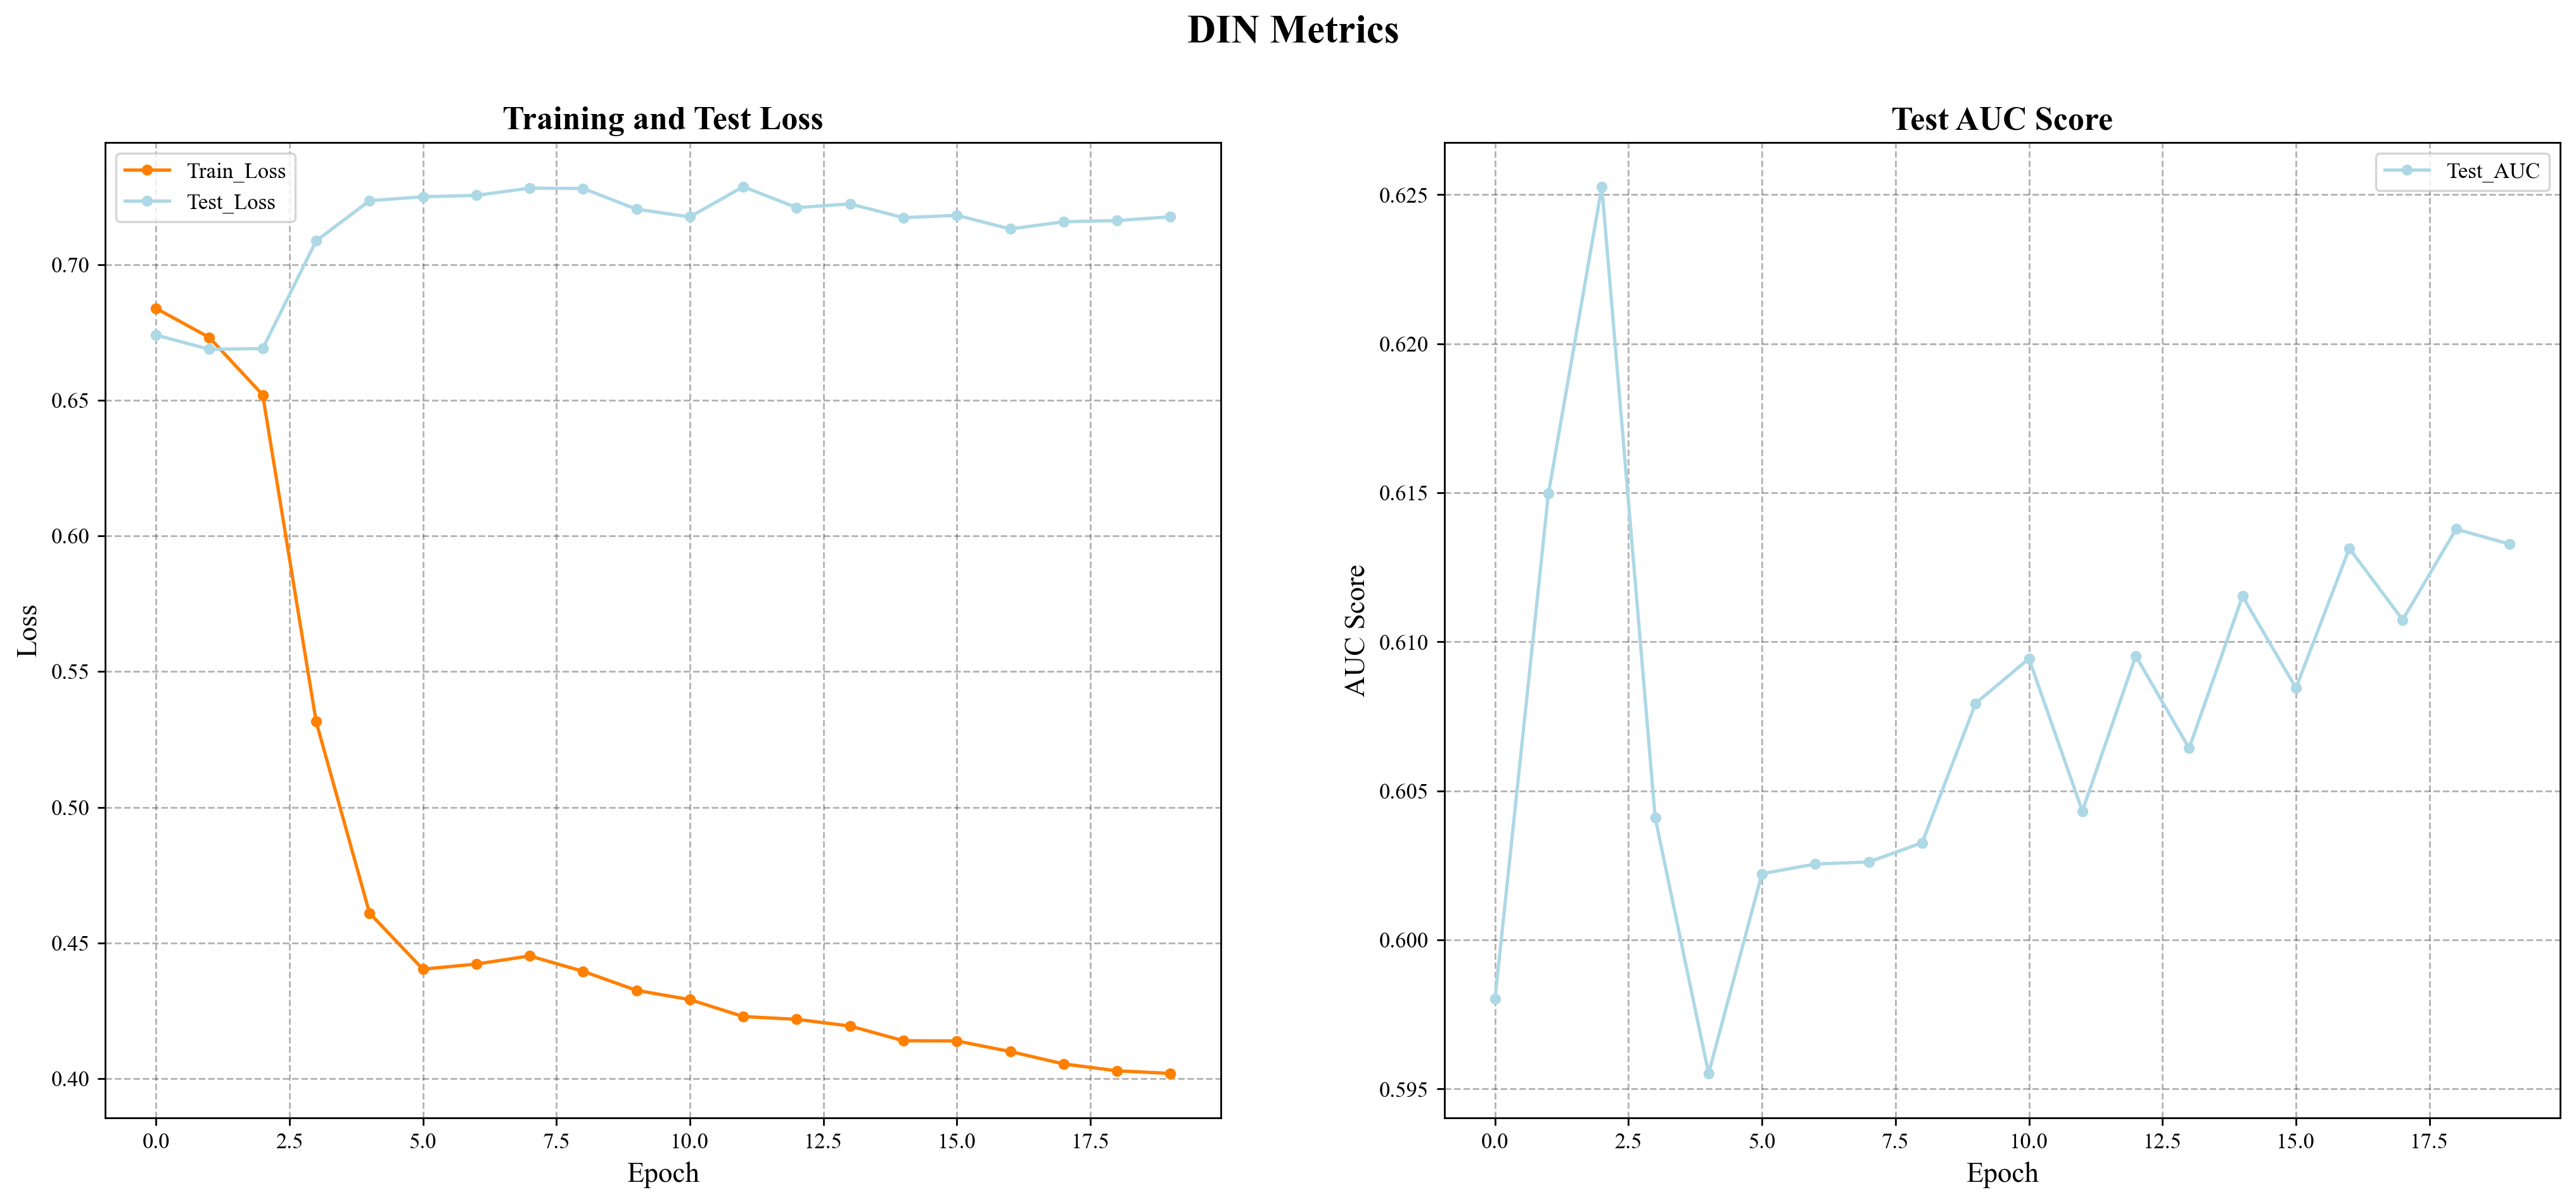

In [89]:
# 模型评估
fig, ax = plt.subplots(1, 2, figsize=(20, 8), dpi=250)
ax = ax.flatten()

# 绘制训练和测试损失
ax[0].set_title('Training and Test Loss', weight='bold', fontsize=15)
ax[0].set_xlabel('Epoch', fontsize=13)
ax[0].set_ylabel('Loss', fontsize=13)
ax[0].grid(linestyle='--', alpha=0.3, color='black')
ax[0].plot(trian_loss_history , color='#FF7F00', label='Train_Loss', zorder=2, marker='o', markersize=4)
ax[0].plot(test_loss_history, color='lightblue', label='Test_Loss', zorder=2, marker='o', markersize=4)
ax[0].legend()

# 绘制训练和测试 AUC 分数
ax[1].set_title('Test AUC Score', weight='bold', fontsize=15)
ax[1].set_xlabel('Epoch', fontsize=13)
ax[1].set_ylabel('AUC Score', fontsize=13)
ax[1].grid(linestyle='--', alpha=0.3, color='black', zorder=0)
ax[1].plot(auc_history, color='lightblue', label='Test_AUC', zorder=2, marker='o', markersize=4)
ax[1].legend()

fig.suptitle('DIN Metrics', fontsize=18, fontweight='bold')

plt.show()